In [1]:
import numpy as np
import pandas as pd

import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")
alt.data_transformers.disable_max_rows()

import copy
import os
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

In [2]:
sap_sugar_df = pd.read_pickle('data/processed/stinson2019/norm_tables/sap_sugar_weekly_summary')

gdd_frthw = pd.read_pickle('data/processed/stinson2019/norm_tables/gdd_frthw')
closest_weather_stn = pd.read_pickle('data/processed/stinson2019/norm_tables/closest_weather_stn')
gdd_frthw = gdd_frthw.merge(closest_weather_stn.reset_index(), how = 'left', on= 'stn_id')
gdd_frthw = gdd_frthw.set_index('datetime')

full_weekly = pd.read_pickle('data/processed/stinson2019/full_weekly_summary')

In [3]:
location = pd.read_pickle('data/processed/stinson2019/norm_tables/location')
location

,lat,lon,short_name,long_name,state_province
site,,,,,
DOF,43.733800,-72.249000,Dartmouth,Dartmouth Organic Farm,NH
QC,48.430919,-70.688456,Boris,Boris,QC
HF,42.531500,-72.189900,Harvard,Harvard Forest,MA
INDU,41.625400,-87.081100,Indiana Dunes,Indiana Dunes National Lakeshore,IN
SMM,38.235181,-79.657058,Southernmost,Southernmost Maple,VA
DR,37.010800,-82.676400,Divide Ridge,Divide Ridge,VA


In [4]:
full_sap = pd.DataFrame(
    columns=[
        "tap_id",
        "date_from",
        "date_to",
        "weekly_sugarwt",
        "weekly_sap",
        "site",
        "cumGDD",
        "cum_frthw",
        "weekly_frthw",
        "sap_binary",
    ]
)

for site in sap_sugar_df.site.unique():
    sap_sugar_site = sap_sugar_df[sap_sugar_df.site == site]
    for tap in sap_sugar_site.tap_id.unique():
        sap_sugar_tap = sap_sugar_site[sap_sugar_site.tap_id == tap]
        for year in sap_sugar_tap.date_to.dt.year.unique():
            sap_sugar_year = sap_sugar_tap[sap_sugar_tap.date_to.dt.year == year].drop(columns=['site'])

            # Merge weather from local station with sap measurements for a given tap and year
            sap_sugar_year = sap_sugar_year.merge(
                gdd_frthw[(gdd_frthw.site == site) & (gdd_frthw.index.year == year)],
                how="right",
                left_on=["date_to"],
                right_index=True,
            )
            
            # Add missing dates, tapids to df
            sap_sugar_year.loc[:,'date_from'] = sap_sugar_year.loc[:,'date_to'] - pd.DateOffset(6)
            sap_sugar_year['weather_datetime'] = sap_sugar_year.date_to
            sap_sugar_year['tap_id'] = sap_sugar_year['tap_id'].fillna(tap)
                        
                        
            
            # Fill in missing 0 values
            sap_sugar_year.loc[:,'weekly_sugarwt'] = sap_sugar_year.loc[:,'weekly_sugarwt'].fillna(0)
            sap_sugar_year.loc[:,'weekly_sap'] = sap_sugar_year.loc[:,'weekly_sap'].fillna(0)
            
            # Add total weekly freeze-thaw cycles column (week ending on date 'date_to')
            sap_sugar_year = sap_sugar_year.rename(columns={'frthw':'cum_frthw'})
            sap_sugar_year.loc[:, "weekly_frthw"] = sap_sugar_year.loc[:, "cum_frthw"] - sap_sugar_year.loc[:, "cum_frthw"].shift(6)

            # Add column indicating if there was any sap flow in a given week
            sap_sugar_year["sap_binary"] = sap_sugar_year["weekly_sap"].apply(
                lambda x: 0 if ((pd.isnull(x)) | (x == 0)) else 1
            )
            
            
            

            full_sap = full_sap.append(sap_sugar_year)

full_sap.sap_binary = full_sap.sap_binary.astype("int")
full_sap.reset_index(inplace=True)

sap_sugar_sitealysis, Houle et al. (2015) created a logistic regression model to predict the presence or absence of maple syrup production in a given week.  The following linear function was developed based on their measured data (note: signs have been reversed:

$$ P = -5.09 + 0.722F - 0.014F^2 - 0.07G$$

Where:

$P$ = Predictor of whether there will or will not be sap flowing in a given week (variable is labelled 'Production' in Houle et al., 2015)

$F$ = Cumulative number of freeze/thaw events since the beginning of the year (January 1st).  A freeze/thaw event is counted if the temperature rises above a given threshold ($T_{thresh}$) and drops below it again.  A threshold of 3&deg;C has been used as in Houle et al., 2015.

$G$ = Cumulative number of growing degree days since the beginning of the year (January 1st) using a 5&deg;C base temperature ($T_{base}$).  Each day, the maximum air temperature ($T_{max}$is extracted and, if it is above the $T_{base}$, a value of $T_{base} - T_{max}$ is added to the running total of growing degree days ($G$).

Passing $P$ into a sigmoid function and applying a threshold of 0.51, we end up with a prediction of whether there will or will not be sap flow in a given week.

$$\hat{Y} = \begin{cases}
1 & \text{if} \ \frac{1}{1+e^{-P}} \geq 0.51 \\
0 & \text{if} \ \frac{1}{1+e^{-P}} < 0.51
\end{cases}
$$


In [5]:
full_sap

,index,tap_id,date_from,date_to,weekly_sugarwt,weekly_sap,site,cumGDD,cum_frthw,weekly_frthw,sap_binary,stn_id,mean_airt,GDD,weather_datetime
0,NaN,DOF1A,2013-12-26,2014-01-01,0.0,0.0,DOF,0.000000,0.0,NaN,0,726116-94765,-12.637500,0.000000,2014-01-01
1,NaN,DOF1A,2013-12-27,2014-01-02,0.0,0.0,DOF,0.000000,0.0,NaN,0,726116-94765,-15.128571,0.000000,2014-01-02
2,NaN,DOF1A,2013-12-28,2014-01-03,0.0,0.0,DOF,0.000000,0.0,NaN,0,726116-94765,-16.711475,0.000000,2014-01-03
3,NaN,DOF1A,2013-12-29,2014-01-04,0.0,0.0,DOF,0.000000,0.0,NaN,0,726116-94765,-20.695833,0.000000,2014-01-04
4,NaN,DOF1A,2013-12-30,2014-01-05,0.0,0.0,DOF,0.000000,0.0,NaN,0,726116-94765,-10.392000,0.000000,2014-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200999,NaN,SMAS8B,2016-12-21,2016-12-27,0.0,0.0,SMM,2685.531177,77.5,5.0,0,724115-93757,10.322581,5.322581,2016-12-27
201000,NaN,SMAS8B,2016-12-22,2016-12-28,0.0,0.0,SMM,2685.531177,79.0,6.0,0,724115-93757,1.060606,0.000000,2016-12-28
201001,NaN,SMAS8B,2016-12-23,2016-12-29,0.0,0.0,SMM,2685.531177,82.0,7.5,0,724115-93757,1.950000,0.000000,2016-12-29
201002,NaN,SMAS8B,2016-12-24,2016-12-30,0.0,0.0,SMM,2685.531177,82.0,6.5,0,724115-93757,-4.862069,0.000000,2016-12-30


In [6]:
# Coefficients of linear model created by Houle 2015 and threshold for predicting 'True' for sap flow from logistic function
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07])
houle_thresh = 0.51   

# Create dataframe of parameters required for Houle 2015 analysis
houle2015 = full_sap[['site', 'tap_id', 'date_from', 'date_to', 'cum_frthw', 'cumGDD', 'sap_binary']]
houle2015 = houle2015.rename(columns={'cum_frthw':'F', 'cumGDD':'G', 'sap_binary':'Y'})


# Add F**2 column
houle2015['F2'] = houle2015.F**2



# Add bias column
houle2015['bias'] = 1
houle2015.loc[:,'P'] = houle2015[['bias', 'F', 'F2', 'G']]@(houle_coeff) 
houle2015.loc[:,'S'] = 1/(1 + np.exp(-houle2015['P']))  # Add intermediate sigmoid output column 'S'
houle2015.loc[:,'Y_hat'] = (houle2015['S'] > houle_thresh).astype('int') # Threshold determined by Houle 2015
houle2015.loc[:,'correct'] = (houle2015.Y_hat == houle2015.Y).astype('int')  # Add column indicating if prediction was correct or not


houle2015['jd'] = houle2015['date_to'].dt.dayofyear
houle2015['year'] = houle2015['date_to'].dt.year

houle2015['tp'] = houle2015.apply(lambda x: 1 if (x.Y==1 and x.Y_hat==1) else 0, axis=1)
houle2015['fp'] = houle2015.apply(lambda x: 1 if (x.Y==0 and x.Y_hat==1) else 0, axis=1)
houle2015['fn'] = houle2015.apply(lambda x: 1 if (x.Y==1 and x.Y_hat==0) else 0, axis=1)
houle2015['tn'] = houle2015.apply(lambda x: 1 if (x.Y==0 and x.Y_hat==0) else 0, axis=1)




In [7]:
houle_summary = houle2015[['site','tap_id','year', 'tn', 'fp', 'fn', 'tp']].groupby(['tap_id','year', 'site']).sum()
houle_summary['precision_1'] = houle_summary.tp/(houle_summary.tp + houle_summary.fn)
houle_summary['precision_0'] = houle_summary.tn/(houle_summary.tn + houle_summary.fp)
houle_summary = houle_summary.reset_index()
houle_summary = houle_summary.merge(location.reset_index()[['site','long_name','state_province']], on='site',how='left')
houle_summary['loc'] = houle_summary.long_name + ', ' + houle_summary.state_province
houle_summary

,tap_id,year,site,tn,fp,fn,tp,precision_1,precision_0,long_name,state_province,loc
0,DOF10A,2014,DOF,265,62,21,17,0.447368,0.810398,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
1,DOF10A,2015,DOF,322,3,4,36,0.900000,0.990769,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
2,DOF10A,2016,DOF,290,28,32,16,0.333333,0.911950,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
3,DOF10A,2017,DOF,290,40,14,21,0.600000,0.878788,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
4,DOF10B,2014,DOF,265,68,21,11,0.343750,0.795796,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
...,...,...,...,...,...,...,...,...,...,...,...,...
547,SMAS6A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA"
548,SMAS7A,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA"
549,SMAS7B,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA"
550,SMAS8A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA"


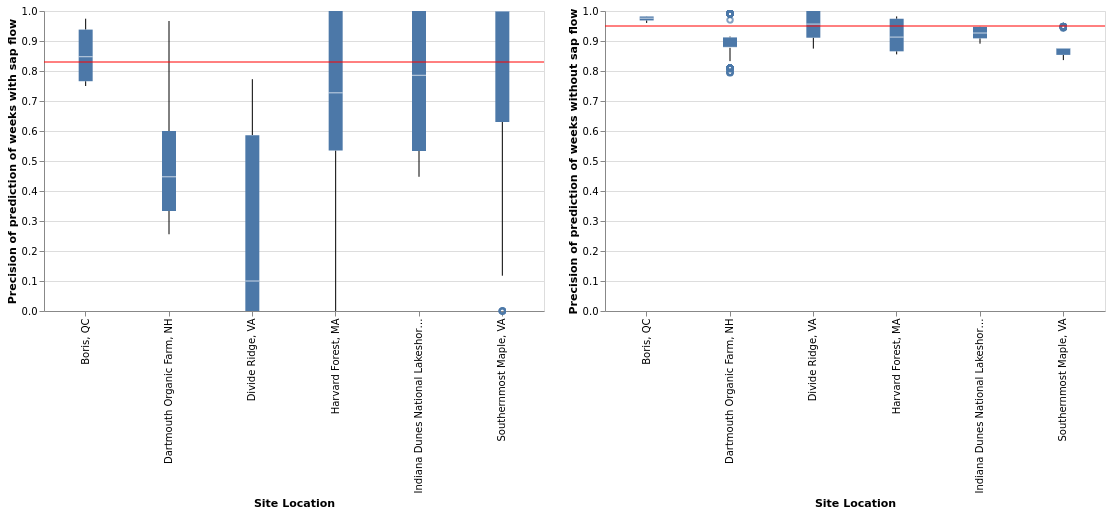

In [8]:
prec_1_plt = alt.Chart(houle_summary).mark_boxplot().encode(
    y=alt.Y("precision_1", title = 'Precision of prediction of weeks with sap flow'),
    x=alt.X("loc", title = 'Site Location')
)
prec_0_plt = alt.Chart(houle_summary).mark_boxplot().encode(
    y=alt.Y("precision_0", title = 'Precision of prediction of weeks without sap flow'),
    x=alt.X("loc", title = 'Site Location')
)

houle_means = pd.DataFrame({'prec_1':[0.83], 'prec_0':[0.95]})

prec_0_plt = prec_0_plt + alt.Chart(houle_means).mark_rule(color='red').encode(y='prec_0')
prec_1_plt = prec_1_plt + alt.Chart(houle_means).mark_rule(color='red').encode(y='prec_1')

width = 500
(prec_1_plt.properties(width=width) | prec_0_plt.properties(width=width))

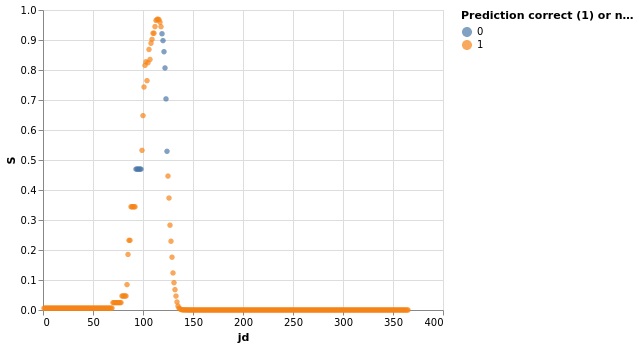

In [9]:
alt.Chart(
    houle2015[
        (houle2015.site == "QC")
        & (houle2015.date_to.dt.year == 2015)
        & (houle2015.tap_id == "QC1A")
    ]
).mark_circle().encode(
    x="jd",
    y="S", 
    fill=alt.Fill("correct:N", title = 'Prediction correct (1) or not (0)'),
)
